# EDA 
## 무엇을 하는 것인가?
EDA(Exploratory Data Analysis)는 수집한 **데이터를 다양한 각도**에서 관찰하며 이해하는 과정입니다.   
데이터를 분석하기 위해서 **시각화나 통계적인 방법**을 사용합니다.   
데이터 분포 및 값을 검토함으로써 데이터가 **표현하는 현상을 확인**할 수 있고 데이터의 **잠재적인 문제를 발견**할 수 있습니다.   
다양한 각도에서 데이터를 바라보면서 **다양한 패턴을 발견하거나 가설을 세울** 수 있게 됩니다.

## 데이터

[GoodReads](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/books?authuser=0)

2017년 하반기 goodreads.com에서 수집된 데이터입니다.(2019년 5월에 업데이트됨)    
goodreads.com은 2007년 1월에 시작된 세계에서 가장 큰 규모의 책 추천 사이트로, 사이트 내 사용자들의 meta data를 바탕으로 개별화된 책 추천 서비스를 제공합니다.  
236만권의 서적, 87만 명의 사용자 사이에서 발생한 2억 2864만건의 interaction 데이터가 포함되어 있습니다.   
3가지 그룹의 데이터를 수집됐습니다.
- (1) **책의 메타 데이터**    
- (2) **사용자-책 interaction(사용자의 public shelves)**    
- (3) 사용자의 책에 관한 리뷰

상위 3개의 데이터는 'book id', 'user id', 'review id'를 바탕으로 병합할 수 있습니다.    
('User ID' 및 'review ID'는 익명화됨)(2)번에 해당하는 데이터셋의 규모가 굉장히 크기에 책의 장르별(총 8가지)로 하위 그룹이 생성돼 관리됩니다.    
다양한 하위 장르 중, 이번 프로젝트에서는 Poetry 장르의 interaction data, book data를 활용했습니다.   

**interaction,book data**를 통해서 여러 특성을 얻을 수 있습니다.   
특성들은 클러스터링, 아이템 추천 등에 사용됩니다.   
도움이 될만한 특성(컬럼)들을 정리해 만든 최종 데이터 프레임은 다음과 같습니다.

**book_data**

- is_ebook : e북 여부
- book_id: 책 id
- is_eng: 책이 영문인지 여부
- num_pages: 책 페이지 수
- publication_year: 출판연도
- publication_month: 출판한 달
- publication_day: 출판한 날짜
- average_rating: 책의 평균 평점
- ratings_count: 책의 전체 평점 개수
- text_reviews_count: 리뷰 개수
- author_average_rating: 작가 평균 평점
- author_ratings_count: 작가 평점 개수
- author_text_reviews_count: 작가 리뷰 개수
- to_read : 해당 책을 읽고 싶다고 표시한 사용자 수
- title	: 책의 이름 
- author_name : 작가의 이름	
- url : goodreads 페이지 주소

**interaction_data**

- user_id : 유저 id 
- book_id : 책 id
- rating : 사용자가 매긴 책의 평점

___

#### Goodreads의 데이터를 활용해 추천 시스템에 활용될 컬럼(특성)들을 파악합니다.


In [ ]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

%matplotlib inline

In [ ]:
file_path = "/aiffel/aiffel/해커톤3"
book_path = file_path + '/goodreads_books_poetry.json.gz'
action_path = file_path + '/goodreads_interactions_poetry.json.gz'
authors_path = file_path + '/goodreads_book_authors.json'

book = pd.read_json(book_path, lines=True, compression='gzip')
action = pd.read_json(action_path, lines=True, compression='gzip')
authors = pd.read_json(authors_path, lines=True)

In [ ]:
book

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,,1,[],US,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",,false,3.83,,...,11,,1887,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,3,5212748,Vision of Sir Launfal and Other Poems,Vision of Sir Launfal and Other Poems
1,0811223981,2,[],US,,"[{'count': '100', 'name': 'to-read'}, {'count'...",,false,3.83,B00U2WY9U8,...,4,,2015,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,37,41905435,Fairy Tales: Dramolettes,Fairy Tales: Dramolettes
2,0374428115,7,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,4.38,,...,7,,2008,https://www.goodreads.com/book/show/926662.Gro...,https://s.gr-assets.com/assets/nophoto/book/11...,926662,45,911665,Growltiger's Last Stand and Other Poems,Growltiger's Last Stand and Other Poems
3,0156182890,12,[],US,,"[{'count': '554', 'name': 'to-read'}, {'count'...",,false,3.71,B00IWTRB1W,...,3,,1964,https://www.goodreads.com/book/show/926667.The...,https://images.gr-assets.com/books/1382939971m...,926667,115,995066,The Cocktail Party,The Cocktail Party
4,1942004192,4,[],US,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",,false,5.00,,...,12,First,2015,https://www.goodreads.com/book/show/29065952-l...,https://images.gr-assets.com/books/1455198396m...,29065952,9,49294781,Louder Than Everything You Love,Louder Than Everything You Love
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36509,,1,[],US,eng,"[{'count': '2', 'name': 'poetry'}, {'count': '...",B004CYF8NY,true,5.00,,...,,,,https://www.goodreads.com/book/show/9874488-ta...,https://s.gr-assets.com/assets/nophoto/book/11...,9874488,1,14766173,Take Out from the Writer's Café,Take Out from the Writer's Café
36510,,1,[714239],US,,"[{'count': '1158', 'name': 'to-read'}, {'count...",B002LIT2S0,true,3.65,B004UK2JO6,...,,,,https://www.goodreads.com/book/show/7657489-a-...,https://s.gr-assets.com/assets/nophoto/book/11...,7657489,3,854054,A Book of Nonsense,A Book of Nonsense
36511,0879230789,1,[],US,,"[{'count': '3', 'name': 'poetry'}]",,false,3.50,,...,,,,https://www.goodreads.com/book/show/3762261-su...,https://s.gr-assets.com/assets/nophoto/book/11...,3762261,2,3806167,Sunbelly (Number 2 in the First Godine Poetry ...,Sunbelly (Number 2 in the First Godine Poetry ...
36512,,4,[],US,spa,"[{'count': '247044', 'name': 'to-read'}, {'cou...",,false,3.73,B008H3RGCW,...,,,2013,https://www.goodreads.com/book/show/23452091-o...,https://images.gr-assets.com/books/1414353152m...,23452091,55,3356006,Odisea,Odisea


In [ ]:
action

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,1384,1bad0122cebb4aa9213f9fe1aa281f66,True,4,,Wed May 09 09:33:44 -0700 2007,Wed May 09 09:33:44 -0700 2007,,
1,8842281e1d1347389f2ab93d60773d4d,1376,eb6e502d0c04d57b43a5a02c21b64ab4,True,4,,Wed May 09 09:33:18 -0700 2007,Wed May 09 09:33:18 -0700 2007,,
2,8842281e1d1347389f2ab93d60773d4d,30119,787564bef16cb1f43e0f641ab59d25b7,True,5,,Sat Jan 13 13:44:20 -0800 2007,Wed Mar 22 11:45:08 -0700 2017,Tue Mar 01 00:00:00 -0800 1983,
3,72fb0d0087d28c832f15776b0d936598,24769928,8c80ee74743d4b3b123dd1a2e0c0bcac,False,0,,Wed Apr 27 11:05:51 -0700 2016,Wed Apr 27 11:05:52 -0700 2016,,
4,72fb0d0087d28c832f15776b0d936598,30119,2a83589fb597309934ec9b1db5876aaf,True,3,,Mon Jun 04 18:58:08 -0700 2012,Mon Jun 04 18:58:13 -0700 2012,,
...,...,...,...,...,...,...,...,...,...,...
2734345,594c86711bd7acdaf655d102df52a9cb,10810038,1b6982ab9342de8d0c560f74598b7b95,False,0,,Thu May 23 12:54:29 -0700 2013,Thu May 23 12:54:29 -0700 2013,,
2734346,594c86711bd7acdaf655d102df52a9cb,4488657,6fccf41aad2ef9d4392b2dc0c14cf77c,False,0,,Sun Apr 28 09:26:58 -0700 2013,Sun Apr 28 09:27:11 -0700 2013,,
2734347,594c86711bd7acdaf655d102df52a9cb,5865674,dea3556a048fc6b75f361baeaa0c49e9,False,0,,Sun Apr 28 09:25:28 -0700 2013,Sun Apr 28 09:25:28 -0700 2013,,
2734348,594c86711bd7acdaf655d102df52a9cb,16170625,a3d153de0b86bdf9eeef0d756f471649,True,5,,Sun Apr 21 16:29:46 -0700 2013,Fri May 31 10:29:35 -0700 2013,,


In [ ]:
authors

,average_rating,author_id,text_reviews_count,name,ratings_count
0,3.98,604031,7,Ronald J. Fields,49
1,4.08,626222,28716,Anita Diamant,546796
2,3.92,10333,5075,Barbara Hambly,122118
3,3.68,9212,36262,Jennifer Weiner,888522
4,3.82,149918,96,Nigel Pennick,1740
...,...,...,...,...,...
829524,4.36,197551,4,Patty Furbush,11
829525,4.33,3988103,3,Jim Schlinkman,6
829526,4.00,13464507,2,Rich Jolly,18
829527,3.31,7427847,1,sr@ mwrGn,13


### 데이터 타입 확인

In [ ]:
book.dtypes

isbn                     object
text_reviews_count        int64
series                   object
country_code             object
language_code            object
popular_shelves          object
asin                     object
is_ebook                 object
average_rating          float64
kindle_asin              object
similar_books            object
description              object
format                   object
link                     object
authors                  object
publisher                object
num_pages                object
publication_day          object
isbn13                   object
publication_month        object
edition_information      object
publication_year         object
url                      object
image_url                object
book_id                   int64
ratings_count             int64
work_id                   int64
title                    object
title_without_series     object
dtype: object

In [ ]:
action.dtypes

user_id                   object
book_id                    int64
review_id                 object
is_read                     bool
rating                     int64
review_text_incomplete    object
date_added                object
date_updated              object
read_at                   object
started_at                object
dtype: object

In [ ]:
authors.dtypes

average_rating        float64
author_id               int64
text_reviews_count      int64
name                   object
ratings_count           int64
dtype: object

### 데이터 전처리

- EDA에 활용할 수 있도록 숫자 데이터로 변경합니다.

In [ ]:
#blank_nan
book = book.replace(r'^\s*$', np.nan, regex=True)
action = action.replace(r'^\s*$', np.nan, regex=True)

#type_cast
book['series'] = book['series'].apply(lambda x : np.nan if not x else x)
book['similar_books'] = book['similar_books'].apply(lambda x : np.nan if not x else x)
book['publication_year'] = pd.to_numeric(book['publication_year'])
book['publication_month'] = pd.to_numeric(book['publication_month'])
book['publication_day'] = pd.to_numeric(book['publication_day'])
book['num_pages'] = pd.to_numeric(book['num_pages'])
book['is_ebook'] = book['is_ebook'].apply(lambda x : 1 if x=='true' else 0)

action['is_read'] = action['is_read'].apply(lambda x : 1 if x else 0)

In [ ]:
print("Interaction shape is {}".format(action.shape))
print("book shape is {}".format(book.shape))

Interaction shape is (2734350, 10)
book shape is (36514, 29)


___

## EDA

메타 데이터와 interaction 데이터를 분석합니다.

### book

In [ ]:
book.isnull().sum()

isbn                     9980
text_reviews_count          0
series                  35076
country_code                0
language_code           19462
popular_shelves             0
asin                    34644
is_ebook                    0
average_rating              0
kindle_asin             26879
similar_books           21094
description              7526
format                   7025
link                        0
authors                     0
publisher                6033
num_pages                7505
publication_day         14956
isbn13                   8155
publication_month       13020
edition_information     33089
publication_year         5816
url                         0
image_url                   0
book_id                     0
ratings_count               0
work_id                     0
title                       2
title_without_series        2
dtype: int64

#### 전체 데이터 수 : 36514

- series, edition_information : 결측치가 너무 많으므로 제거합니다.    
- series가 제거 됐으므로 title_without_series도 필요 없어져서 제거합니다.
- country_code : US만 존재 -> 제거합니다.
- isbn, asin과 같은 의미 없는 일련 번호도 제거합니다.
- url, link, img-url과 같은 의미가 중복되는 컬럼 중 url만 남기고 제거합니다.

In [ ]:
book['country_code'].nunique()

1

In [ ]:
book_data = book.drop(['isbn','series','country_code','asin','kindle_asin','description','link','isbn13','image_url','edition_information','work_id','title_without_series'],axis = 1)
book_data.head(5)

,text_reviews_count,language_code,popular_shelves,is_ebook,average_rating,similar_books,format,authors,publisher,num_pages,publication_day,publication_month,publication_year,url,book_id,ratings_count,title
0,1,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",0,3.83,NaN,Paperback,"[{'author_id': '15585', 'role': ''}]","Houghton, Mifflin and Company",80.0,1.0,11.0,1887.0,https://www.goodreads.com/book/show/16037549-v...,16037549,3,Vision of Sir Launfal and Other Poems
1,2,NaN,"[{'count': '100', 'name': 'to-read'}, {'count'...",0,3.83,NaN,Paperback,"[{'author_id': '16073', 'role': ''}, {'author_...",New Directions,128.0,20.0,4.0,2015.0,https://www.goodreads.com/book/show/22466716-f...,22466716,37,Fairy Tales: Dramolettes
2,7,NaN,"[{'count': '32', 'name': 'to-read'}, {'count':...",0,4.38,NaN,Paperback,"[{'author_id': '18540', 'role': ''}, {'author_...",Farrar Straus Giroux,NaN,12.0,7.0,2008.0,https://www.goodreads.com/book/show/926662.Gro...,926662,45,Growltiger's Last Stand and Other Poems
3,12,NaN,"[{'count': '554', 'name': 'to-read'}, {'count'...",0,3.71,"[1230072, 315167, 676169, 18522, 124335, 88263...",Paperback,"[{'author_id': '18540', 'role': ''}]",Mariner Books,190.0,18.0,3.0,1964.0,https://www.goodreads.com/book/show/926667.The...,926667,115,The Cocktail Party
4,4,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",0,5.00,"[25869488, 23630890, 25448131, 25464039, 42166...",Paperback,"[{'author_id': '14308759', 'role': ''}]",ELJ Publications,118.0,23.0,12.0,2015.0,https://www.goodreads.com/book/show/29065952-l...,29065952,9,Louder Than Everything You Love


In [ ]:
book_data_count = book_data.drop(['popular_shelves','authors','similar_books'],axis=1)
book_data_count.nunique()

text_reviews_count      421
language_code            92
is_ebook                  2
average_rating          282
format                  196
publisher              8185
num_pages              1058
publication_day          31
publication_month        12
publication_year        201
url                   36514
book_id               36514
ratings_count          1725
title                 29726
dtype: int64

___

#### 숫자형 변수 확인

날짜 정보

In [ ]:
book_data['publication_year'].describe()

count    30698.000000
mean      2001.058831
std        109.876968
min          0.000000
25%       1998.000000
50%       2007.000000
75%       2012.000000
max      20012.000000
Name: publication_year, dtype: float64

해당 범위에 속한 데이터가 매우 적기 때문에 제거합니다.

In [ ]:
book_data[(book_data['publication_year'] > 2018) | (book_data['publication_year'] <= 1000)]

,text_reviews_count,language_code,popular_shelves,is_ebook,average_rating,similar_books,format,authors,publisher,num_pages,publication_day,publication_month,publication_year,url,book_id,ratings_count,title
6047,1,eng,"[{'count': '4', 'name': 'to-read'}, {'count': ...",0,3.91,NaN,Paperback,"[{'author_id': '50090', 'role': ''}]",Knopf,128.0,20.0,9.0,2106.0,https://www.goodreads.com/book/show/36098998-odes,36098998,11,Odes
6234,1,eng,"[{'count': '13', 'name': 'to-read'}, {'count':...",0,3.67,NaN,Unknown Binding,"[{'author_id': '4106819', 'role': ''}]",NaN,NaN,NaN,NaN,0.0,https://www.goodreads.com/book/show/18808058-t...,18808058,3,The Poems of Anyte of Tegea
9600,4,fil,"[{'count': '98', 'name': 'to-read'}, {'count':...",0,3.68,NaN,Bookpaper,"[{'author_id': '1799563', 'role': ''}]","Anvil Publishing, Inc.",88.0,NaN,NaN,2204.0,https://www.goodreads.com/book/show/16052910-a...,16052910,21,Ang Hayop na Ito!
12041,2,spa,"[{'count': '25', 'name': 'to-read'}, {'count':...",0,4.48,NaN,Paperback,"[{'author_id': '500', 'role': ''}]",Debolsillo,214.0,NaN,8.0,2021.0,https://www.goodreads.com/book/show/21938718-e...,21938718,31,"El otro, el mismo/Para las seis cuerdas/Elogio..."
17573,1,spa,"[{'count': '10', 'name': 'to-read'}, {'count':...",0,3.04,NaN,NaN,"[{'author_id': '34597', 'role': ''}]",NaN,NaN,28.0,9.0,148.0,https://www.goodreads.com/book/show/4936820-la...,4936820,14,Laberinto de Fortuna
17667,2,eng,"[{'count': '6799', 'name': 'to-read'}, {'count...",0,4.30,"[1077318, 821000, 8801, 2643857, 36944, 397157...","Hardback, cloth","[{'author_id': '854076', 'role': ''}]",Charles Scribner's Sons,105.0,NaN,NaN,0.0,https://www.goodreads.com/book/show/3235543-a-...,3235543,4,A Child's Garden of Verses
17784,1,NaN,"[{'count': '23', 'name': 'to-read'}, {'count':...",0,4.39,NaN,Paperback,"[{'author_id': '769910', 'role': ''}]",Humanitas,2010.0,NaN,NaN,152.0,https://www.goodreads.com/book/show/11027605-p...,11027605,23,Patria mea A4
18308,4,fil,"[{'count': '31', 'name': 'to-read'}, {'count':...",0,3.70,NaN,Paperback,"[{'author_id': '1799563', 'role': ''}]","Anvil Publishing, Inc.",86.0,NaN,NaN,2204.0,https://www.goodreads.com/book/show/16052906-e...,16052906,20,Estremelenggoles
21823,1,tur,"[{'count': '455', 'name': 'to-read'}, {'count'...",0,4.35,"[171091, 106458, 929332, 1258536, 139783, 8221...",Paperback,"[{'author_id': '7906', 'role': ''}, {'author_i...",Cem Yayinevi,78.0,NaN,NaN,20012.0,https://www.goodreads.com/book/show/32729484-o...,32729484,0,Orpheus’a Soneler


In [ ]:
book_data['publication_year'][21823] = 2012
book_data.drop([6047,6234,9600,12041,17573, 17667,17784,18308], axis=0, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


___

year 시각화

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='publication_year', ylabel='Density'>

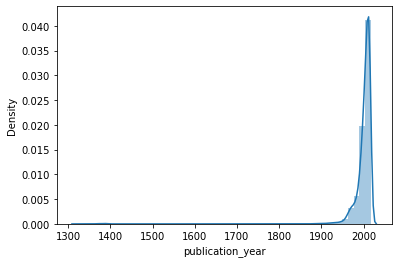

In [ ]:
sns.distplot(book_data['publication_year'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(1900.0, 2018.0)

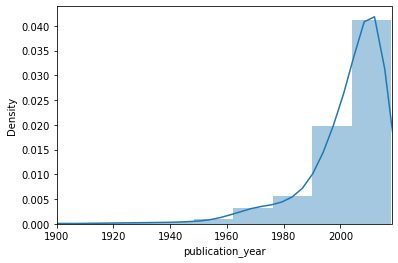

In [ ]:
fig, ax = plt.subplots()
sns.distplot(book_data['publication_year'],ax=ax)
ax.set_xlim(1900,2018)

month 시각화

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='publication_month', ylabel='Density'>

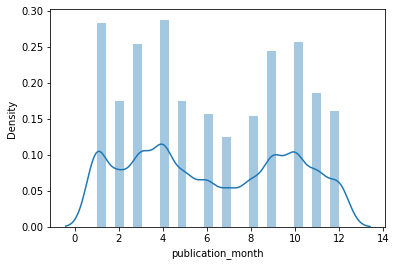

In [ ]:
sns.distplot(book_data['publication_month'])

day 시각화

In [ ]:
book_data['publication_day'].describe()

count    21556.000000
mean        10.863565
std         10.133614
min          1.000000
25%          1.000000
50%          8.000000
75%         19.000000
max         31.000000
Name: publication_day, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='publication_day', ylabel='Density'>

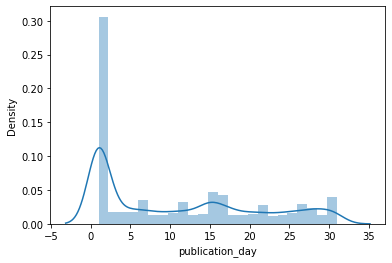

In [ ]:
sns.distplot(book_data['publication_day'])

rating, review 정보 시각화

- 가장 많이 평가된 작품?

In [ ]:
most_rated = book_data.sort_values('ratings_count', ascending = False).head(10).set_index('title')
most_rated['ratings_count']

title
Where the Sidewalk Ends           1029527
The Odyssey                        680823
Hamlet                             526122
A Light in the Attic               304689
The Iliad                          247108
The Complete Stories and Poems     161550
The Canterbury Tales               150099
The Prophet                        145579
Paradise Lost                       97784
Milk and Honey                      92450
Name: ratings_count, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Most rated Book'}, xlabel='ratings_count', ylabel='title'>

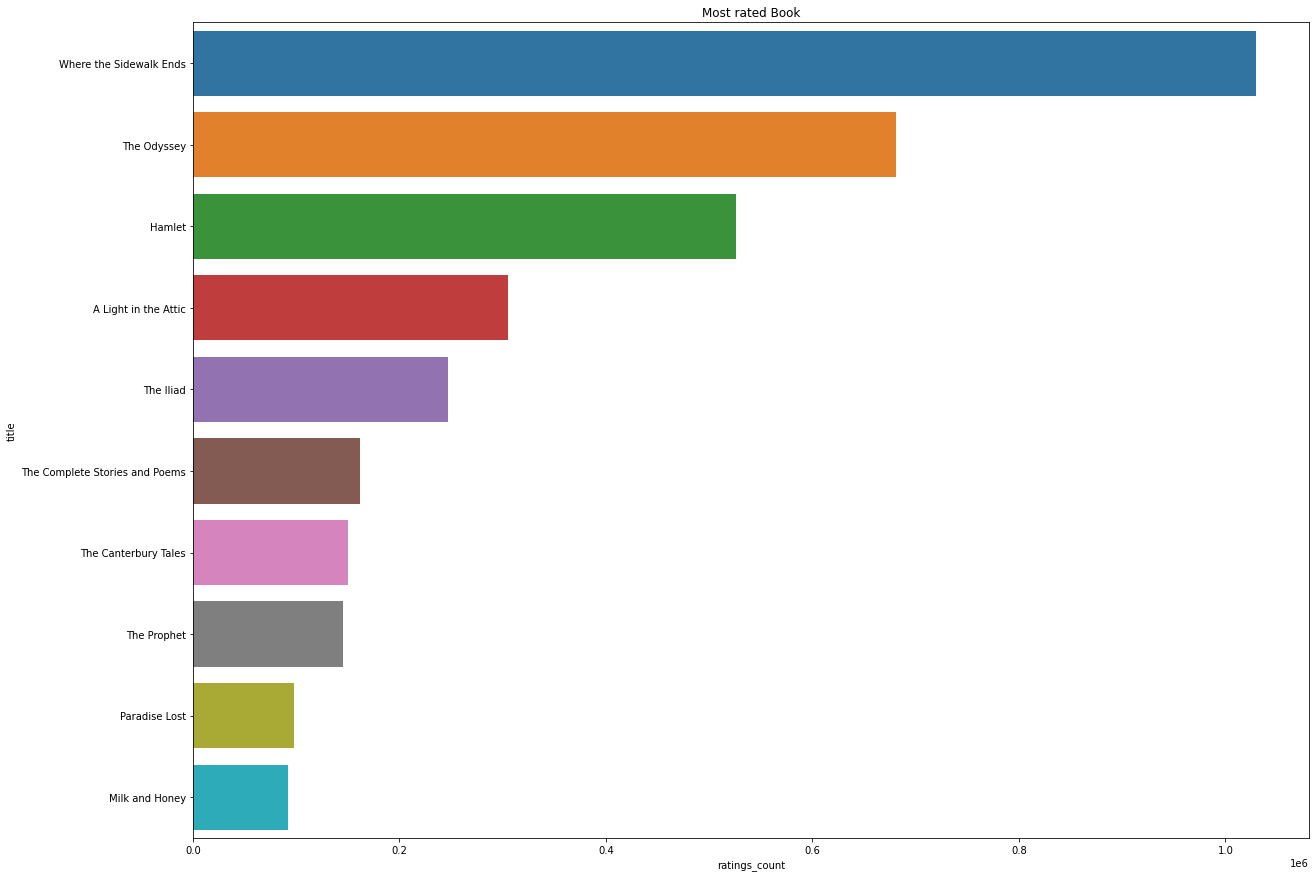

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Most rated Book")
sns.barplot(most_rated['ratings_count'], most_rated.index)

평가 수

In [ ]:
book_data['ratings_count'].describe()

count    3.650600e+04
mean     2.797460e+02
std      7.634250e+03
min      0.000000e+00
25%      9.000000e+00
50%      2.300000e+01
75%      6.900000e+01
max      1.029527e+06
Name: ratings_count, dtype: float64

매우 치우쳐진 데이터

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ratings_count', ylabel='Density'>

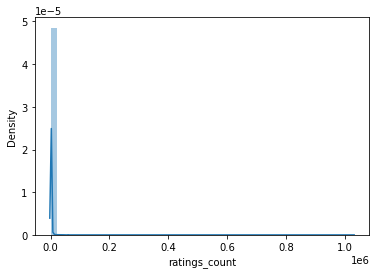

In [ ]:
sns.distplot(book_data['ratings_count'])

log화 해서 활용

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ratings_count', ylabel='Density'>

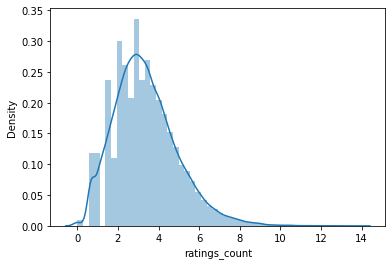

In [ ]:
sns.distplot(np.log1p(book_data['ratings_count']))

리뷰 수

In [ ]:
book_data['text_reviews_count'].describe()

count    36506.000000
mean        14.693667
std        110.606330
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max      10403.000000
Name: text_reviews_count, dtype: float64

매우 치우쳐진 데이터

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text_reviews_count', ylabel='Density'>

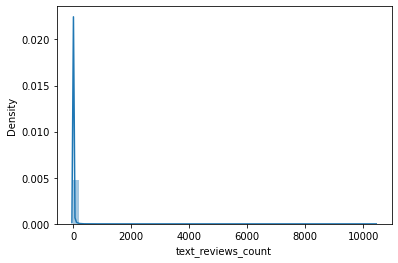

In [ ]:
sns.distplot(book_data['text_reviews_count'])

log화 해서 활용

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text_reviews_count', ylabel='Density'>

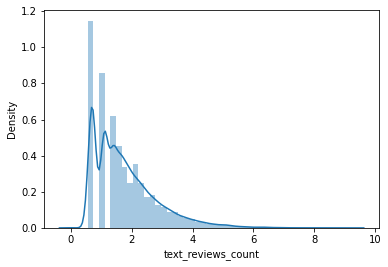

In [ ]:
sns.distplot(np.log1p(book_data['text_reviews_count']))

평균 별점

In [ ]:
book_data['average_rating'].describe()

count    36506.000000
mean         4.063875
std          0.399946
min          0.000000
25%          3.840000
50%          4.100000
75%          4.310000
max          5.000000
Name: average_rating, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='average_rating', ylabel='Density'>

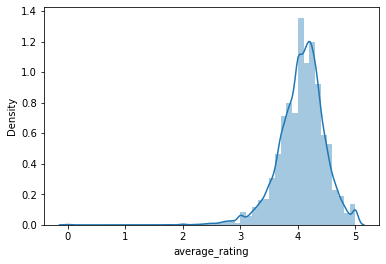

In [ ]:
sns.distplot(book_data['average_rating'])

popular_shelves 정보 추출
- 공통적으로 반복되는 to_read 추출

In [ ]:
book_data['popular_shelves']

0        [{'count': '8', 'name': 'to-read'}, {'count': ...
1        [{'count': '100', 'name': 'to-read'}, {'count'...
2        [{'count': '32', 'name': 'to-read'}, {'count':...
3        [{'count': '554', 'name': 'to-read'}, {'count'...
4        [{'count': '228', 'name': 'to-read'}, {'count'...
                               ...                        
36509    [{'count': '2', 'name': 'poetry'}, {'count': '...
36510    [{'count': '1158', 'name': 'to-read'}, {'count...
36511                   [{'count': '3', 'name': 'poetry'}]
36512    [{'count': '247044', 'name': 'to-read'}, {'cou...
36513    [{'count': '37', 'name': 'to-read'}, {'count':...
Name: popular_shelves, Length: 36506, dtype: object

In [ ]:
book_data['to_read'] = book_data['popular_shelves'].apply(lambda x : x[0]).apply(lambda x : x['count']).astype(int)

In [ ]:
book_data['to_read'].describe()

count     36506.000000
mean       2754.888868
std       19401.433319
min           1.000000
25%          16.000000
50%          66.000000
75%         361.000000
max      247044.000000
Name: to_read, dtype: float64

to_read

치우쳐진 데이터

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='to_read', ylabel='Density'>

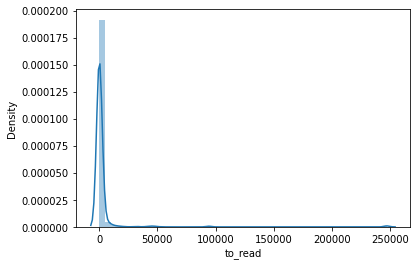

In [ ]:
sns.distplot(book_data['to_read'])

log화 필요

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='to_read', ylabel='Density'>

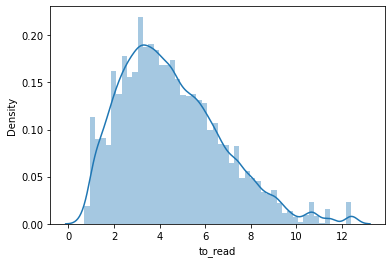

In [ ]:
sns.distplot(np.log1p(book_data['to_read']))

In [ ]:
book_data['popular_shelves'][0]

[{'count': '8', 'name': 'to-read'},
 {'count': '3', 'name': 'poetry'},
 {'count': '2', 'name': 'currently-reading'},
 {'count': '1', 'name': '01-kindle'},
 {'count': '1', 'name': 'real-books'},
 {'count': '1', 'name': 'personal-library'}]

num_pages

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_pages', ylabel='Density'>

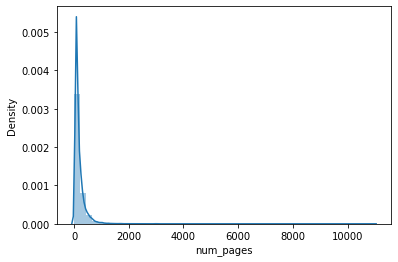

In [ ]:
sns.distplot(book_data['num_pages'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_pages', ylabel='Density'>

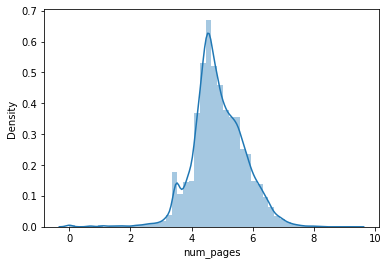

In [ ]:
sns.distplot(np.log1p(book_data['num_pages']))

authors 정보 활용

- book id 기준 병합

In [ ]:
book_data['authors'][1][0]

{'author_id': '16073', 'role': ''}

In [ ]:
book_data['author_id'] = book_data['authors'].apply(lambda x : x[0]).apply(lambda x : x['author_id']).astype(int)
book_data

,text_reviews_count,language_code,popular_shelves,is_ebook,average_rating,similar_books,format,authors,publisher,num_pages,publication_day,publication_month,publication_year,url,book_id,ratings_count,title,to_read,author_id
0,1,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",0,3.83,NaN,Paperback,"[{'author_id': '15585', 'role': ''}]","Houghton, Mifflin and Company",80.0,1.0,11.0,1887.0,https://www.goodreads.com/book/show/16037549-v...,16037549,3,Vision of Sir Launfal and Other Poems,8,15585
1,2,NaN,"[{'count': '100', 'name': 'to-read'}, {'count'...",0,3.83,NaN,Paperback,"[{'author_id': '16073', 'role': ''}, {'author_...",New Directions,128.0,20.0,4.0,2015.0,https://www.goodreads.com/book/show/22466716-f...,22466716,37,Fairy Tales: Dramolettes,100,16073
2,7,NaN,"[{'count': '32', 'name': 'to-read'}, {'count':...",0,4.38,NaN,Paperback,"[{'author_id': '18540', 'role': ''}, {'author_...",Farrar Straus Giroux,NaN,12.0,7.0,2008.0,https://www.goodreads.com/book/show/926662.Gro...,926662,45,Growltiger's Last Stand and Other Poems,32,18540
3,12,NaN,"[{'count': '554', 'name': 'to-read'}, {'count'...",0,3.71,"[1230072, 315167, 676169, 18522, 124335, 88263...",Paperback,"[{'author_id': '18540', 'role': ''}]",Mariner Books,190.0,18.0,3.0,1964.0,https://www.goodreads.com/book/show/926667.The...,926667,115,The Cocktail Party,554,18540
4,4,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",0,5.00,"[25869488, 23630890, 25448131, 25464039, 42166...",Paperback,"[{'author_id': '14308759', 'role': ''}]",ELJ Publications,118.0,23.0,12.0,2015.0,https://www.goodreads.com/book/show/29065952-l...,29065952,9,Louder Than Everything You Love,228,14308759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36509,1,eng,"[{'count': '2', 'name': 'poetry'}, {'count': '...",1,5.00,NaN,NaN,"[{'author_id': '4502880', 'role': ''}]",NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/9874488-ta...,9874488,1,Take Out from the Writer's Café,2,4502880
36510,1,NaN,"[{'count': '1158', 'name': 'to-read'}, {'count...",1,3.65,"[1413520, 2212982, 1294378, 1240904, 1693449, ...",NaN,"[{'author_id': '142', 'role': ''}]",NaN,288.0,NaN,NaN,NaN,https://www.goodreads.com/book/show/7657489-a-...,7657489,3,A Book of Nonsense,1158,142
36511,1,NaN,"[{'count': '3', 'name': 'poetry'}]",0,3.50,NaN,NaN,"[{'author_id': '1023504', 'role': ''}]",NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/3762261-su...,3762261,2,Sunbelly (Number 2 in the First Godine Poetry ...,3,1023504
36512,4,spa,"[{'count': '247044', 'name': 'to-read'}, {'cou...",0,3.73,"[12914, 904843, 235719, 279456, 1536, 27417, 1...",NaN,"[{'author_id': '903', 'role': ''}]",Espasa,487.0,NaN,NaN,2013.0,https://www.goodreads.com/book/show/23452091-o...,23452091,55,Odisea,247044,903


In [ ]:
authors.columns = ['author_average_rating','author_id','author_text_reviews_count','author_name','author_ratings_count']
authors.head(5)

,author_average_rating,author_id,author_text_reviews_count,author_name,author_ratings_count
0,3.98,604031,7,Ronald J. Fields,49
1,4.08,626222,28716,Anita Diamant,546796
2,3.92,10333,5075,Barbara Hambly,122118
3,3.68,9212,36262,Jennifer Weiner,888522
4,3.82,149918,96,Nigel Pennick,1740


In [ ]:
authors.isnull().sum()

author_average_rating        0
author_id                    0
author_text_reviews_count    0
author_name                  0
author_ratings_count         0
dtype: int64

In [ ]:
authors.nunique()

author_average_rating           377
author_id                    829529
author_text_reviews_count      6241
author_name                  825851
author_ratings_count          19686
dtype: int64

In [ ]:
book_data = pd.merge(book_data, authors, on='author_id')
book_data

,text_reviews_count,language_code,popular_shelves,is_ebook,average_rating,similar_books,format,authors,publisher,num_pages,...,url,book_id,ratings_count,title,to_read,author_id,author_average_rating,author_text_reviews_count,author_name,author_ratings_count
0,1,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",0,3.83,NaN,Paperback,"[{'author_id': '15585', 'role': ''}]","Houghton, Mifflin and Company",80.0,...,https://www.goodreads.com/book/show/16037549-v...,16037549,3,Vision of Sir Launfal and Other Poems,8,15585,4.03,158,James Russell Lowell,1464
1,2,NaN,"[{'count': '100', 'name': 'to-read'}, {'count'...",0,3.83,NaN,Paperback,"[{'author_id': '16073', 'role': ''}, {'author_...",New Directions,128.0,...,https://www.goodreads.com/book/show/22466716-f...,22466716,37,Fairy Tales: Dramolettes,100,16073,4.02,1079,Robert Walser,10359
2,4,eng,"[{'count': '30', 'name': 'to-read'}, {'count':...",0,3.79,NaN,Hardcover,"[{'author_id': '16073', 'role': ''}, {'author_...",New Directions,64.0,...,https://www.goodreads.com/book/show/13447246-t...,13447246,39,Thirty Poems,30,16073,4.02,1079,Robert Walser,10359
3,5,NaN,"[{'count': '60', 'name': 'to-read'}, {'count':...",0,4.46,NaN,Paperback,"[{'author_id': '16073', 'role': ''}, {'author_...",Black Lawrence Press,200.0,...,https://www.goodreads.com/book/show/12740665-o...,12740665,26,Oppressive Light: Selected Poems by Robert Walser,60,16073,4.02,1079,Robert Walser,10359
4,7,NaN,"[{'count': '32', 'name': 'to-read'}, {'count':...",0,4.38,NaN,Paperback,"[{'author_id': '18540', 'role': ''}, {'author_...",Farrar Straus Giroux,NaN,...,https://www.goodreads.com/book/show/926662.Gro...,926662,45,Growltiger's Last Stand and Other Poems,32,18540,4.17,5892,T.S. Eliot,189956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36501,6,NaN,"[{'count': '72', 'name': 'to-read'}, {'count':...",0,4.18,NaN,Print,"[{'author_id': '762470', 'role': ''}]",Teachers & Writers Collaborative,244.0,...,https://www.goodreads.com/book/show/1650010.St...,1650010,35,Structure & Surprise,72,762470,4.18,13,Michael Theune,89
36502,2,NaN,"[{'count': '6', 'name': 'to-read'}, {'count': ...",0,4.62,NaN,Paperback,"[{'author_id': '830349', 'role': ''}]",Pandora Press U. S.,NaN,...,https://www.goodreads.com/book/show/1816786.I_...,1816786,8,I Saw God Dancing (Dreamseeker Poetry Series),6,830349,4.58,4,Cheryl Denise,12
36503,1,NaN,"[{'count': '16', 'name': 'to-read'}, {'count':...",0,4.83,NaN,Paperback,"[{'author_id': '634617', 'role': ''}]",Lulu.com,108.0,...,https://www.goodreads.com/book/show/1330132.El...,1330132,23,Elapsing Speedway Organism,16,634617,4.64,8,Bruce Covey,85
36504,6,NaN,"[{'count': '231', 'name': 'currently-reading'}...",1,3.84,"[60321, 25135410, 1312362, 7146660, 17824744, ...",NaN,"[{'author_id': '8440977', 'role': ''}, {'autho...",NaN,NaN,...,https://www.goodreads.com/book/show/23206799-t...,23206799,118,The Best of Poetry: Thoughts that Breathe and ...,231,8440977,3.91,8,Rudolph Amsel,251


간단한 시각화

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='author_average_rating', ylabel='Density'>

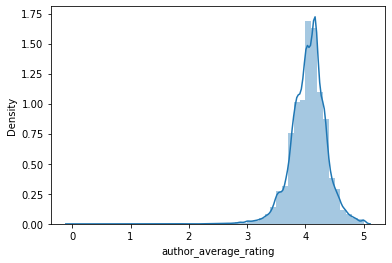

In [ ]:
sns.distplot(book_data['author_average_rating'])

log화 필요?

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='author_text_reviews_count', ylabel='Density'>

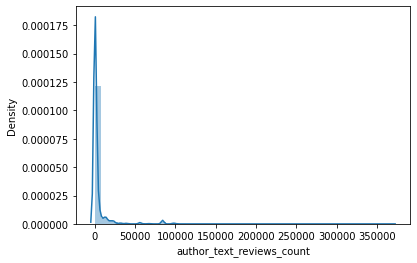

In [ ]:
sns.distplot(book_data['author_text_reviews_count'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='author_ratings_count', ylabel='Density'>

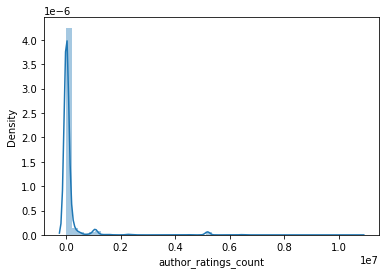

In [ ]:
sns.distplot(book_data['author_ratings_count'])

#### 범주형 데이터

language_code : eng가 대부분
- eng : 1, 나머지 0으로 인코딩

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


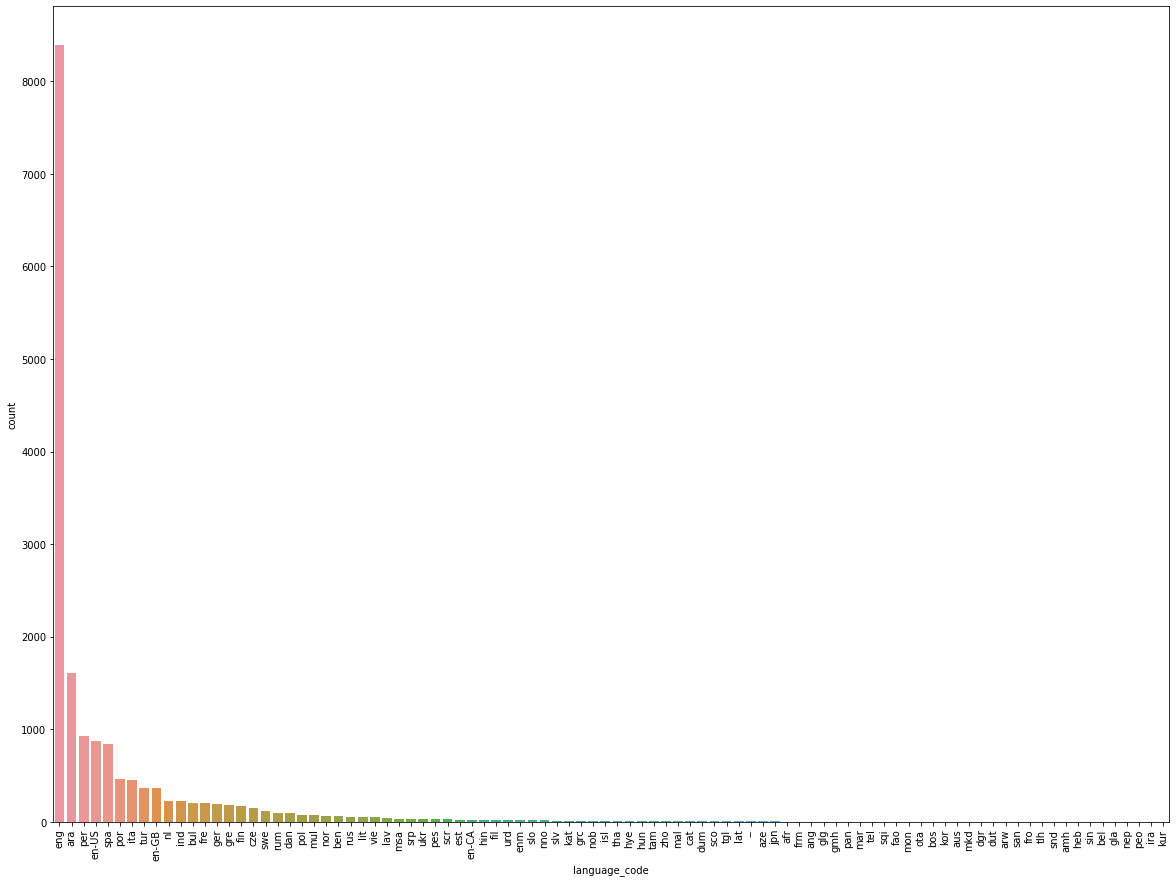

In [ ]:
plt.figure(figsize = (20,15))
sns.countplot('language_code', data = book_data, order = book_data['language_code'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

In [ ]:
book_data['language_code'].value_counts()[:20]

eng      8390
ara      1608
per       924
en-US     868
spa       835
por       462
ita       455
tur       369
en-GB     360
nl        228
ind       222
bul       205
fre       200
ger       193
gre       186
fin       169
cze       154
swe       116
rum       100
dan        92
Name: language_code, dtype: int64

In [ ]:
def is_eng(lang):
    
    if lang == 'eng' or lang == 'en-US' or lang == 'en-GB' or lang == 'en-CA':
        return 1
    elif lang == np.nan:
        return np.nan
    else : 
        return 0

In [ ]:
book_data['is_eng'] = book_data['language_code'].apply(is_eng)
book_data

,text_reviews_count,language_code,popular_shelves,is_ebook,average_rating,similar_books,format,authors,publisher,num_pages,...,book_id,ratings_count,title,to_read,author_id,author_average_rating,author_text_reviews_count,author_name,author_ratings_count,is_eng
0,1,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",0,3.83,NaN,Paperback,"[{'author_id': '15585', 'role': ''}]","Houghton, Mifflin and Company",80.0,...,16037549,3,Vision of Sir Launfal and Other Poems,8,15585,4.03,158,James Russell Lowell,1464,1
1,2,NaN,"[{'count': '100', 'name': 'to-read'}, {'count'...",0,3.83,NaN,Paperback,"[{'author_id': '16073', 'role': ''}, {'author_...",New Directions,128.0,...,22466716,37,Fairy Tales: Dramolettes,100,16073,4.02,1079,Robert Walser,10359,0
2,4,eng,"[{'count': '30', 'name': 'to-read'}, {'count':...",0,3.79,NaN,Hardcover,"[{'author_id': '16073', 'role': ''}, {'author_...",New Directions,64.0,...,13447246,39,Thirty Poems,30,16073,4.02,1079,Robert Walser,10359,1
3,5,NaN,"[{'count': '60', 'name': 'to-read'}, {'count':...",0,4.46,NaN,Paperback,"[{'author_id': '16073', 'role': ''}, {'author_...",Black Lawrence Press,200.0,...,12740665,26,Oppressive Light: Selected Poems by Robert Walser,60,16073,4.02,1079,Robert Walser,10359,0
4,7,NaN,"[{'count': '32', 'name': 'to-read'}, {'count':...",0,4.38,NaN,Paperback,"[{'author_id': '18540', 'role': ''}, {'author_...",Farrar Straus Giroux,NaN,...,926662,45,Growltiger's Last Stand and Other Poems,32,18540,4.17,5892,T.S. Eliot,189956,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36501,6,NaN,"[{'count': '72', 'name': 'to-read'}, {'count':...",0,4.18,NaN,Print,"[{'author_id': '762470', 'role': ''}]",Teachers & Writers Collaborative,244.0,...,1650010,35,Structure & Surprise,72,762470,4.18,13,Michael Theune,89,0
36502,2,NaN,"[{'count': '6', 'name': 'to-read'}, {'count': ...",0,4.62,NaN,Paperback,"[{'author_id': '830349', 'role': ''}]",Pandora Press U. S.,NaN,...,1816786,8,I Saw God Dancing (Dreamseeker Poetry Series),6,830349,4.58,4,Cheryl Denise,12,0
36503,1,NaN,"[{'count': '16', 'name': 'to-read'}, {'count':...",0,4.83,NaN,Paperback,"[{'author_id': '634617', 'role': ''}]",Lulu.com,108.0,...,1330132,23,Elapsing Speedway Organism,16,634617,4.64,8,Bruce Covey,85,0
36504,6,NaN,"[{'count': '231', 'name': 'currently-reading'}...",1,3.84,"[60321, 25135410, 1312362, 7146660, 17824744, ...",NaN,"[{'author_id': '8440977', 'role': ''}, {'autho...",NaN,NaN,...,23206799,118,The Best of Poetry: Thoughts that Breathe and ...,231,8440977,3.91,8,Rudolph Amsel,251,0


is_ebook

- ebook이 아닌 경우가 훨씬 많았다.

<AxesSubplot:xlabel='is_ebook', ylabel='count'>

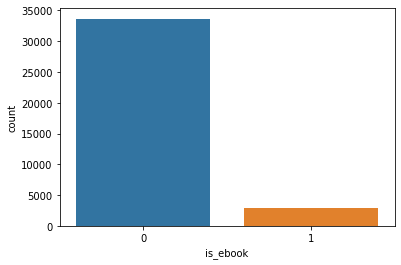

In [ ]:
sns.countplot(x='is_ebook',data = book_data)

format

- 대부분 일반 책이 차지하며 format이 너무 세분화 돼있어서 제거한다.

In [ ]:
set(book_data['format'])

{'10X18',
 '2 audio cassettes',
 'Artist Book',
 'Audible Audio',
 'Audio',
 'Audio CD',
 'Audio Cassette',
 'Audiobook',
 'Audiobook LP',
 'Bia mem',
 'Board Book',
 'Board book',
 'Broche',
 'Brochura',
 'CD-ROM',
 'Casebound',
 'Chapbook',
 'Chapbook (Machine Stitched)',
 'Chapbook/Pamphlet',
 'Comic',
 'Danskt band',
 'Digital publication',
 'E-chap',
 'E-chapbook',
 'Electronic Chapbook',
 'Flexibler Einband',
 'HB',
 'HC',
 'Hand-Crafted Chapbook',
 'Hand-bound',
 'Hand-sewn Binding',
 'Handmade Chapbook',
 'Handmade chapbook',
 'Hard Cover',
 'Hardback',
 'Hardbound',
 'Hardcover',
 'Hardcover + CD rom',
 'Hardcover / glyngwr - jyby',
 'Hardcover / glyngwr - wzyry',
 'Hardcover Art and Poetry Gift Book',
 'Hardcover and Paperback',
 'Hardcover first edition',
 'Hardcover glyngwr',
 'Hardcover, Sewn Binding, Paper Dust Jacket',
 'Hardcover/Paperback',
 'Heftet',
 'Journal',
 'Kindle Edition',
 'Leather Bound',
 'Leatherbound, hard-cover, 5 volumes',
 'Letterpressed Chapbook',
 'L

In [ ]:
freq_format = pd.DataFrame(book_data['format'].value_counts()[:30]).reset_index()
freq_format.columns = ['format','count']
freq_format

,format,count
0,Paperback,20082
1,Hardcover,6735
2,ebook,904
3,Kindle Edition,329
4,Unknown Binding,223
5,Mass Market Paperback,179
6,Audio CD,163
7,Chapbook,93
8,Audiobook,80
9,paperback,61


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Most rated Book'}, xlabel='count', ylabel='format'>

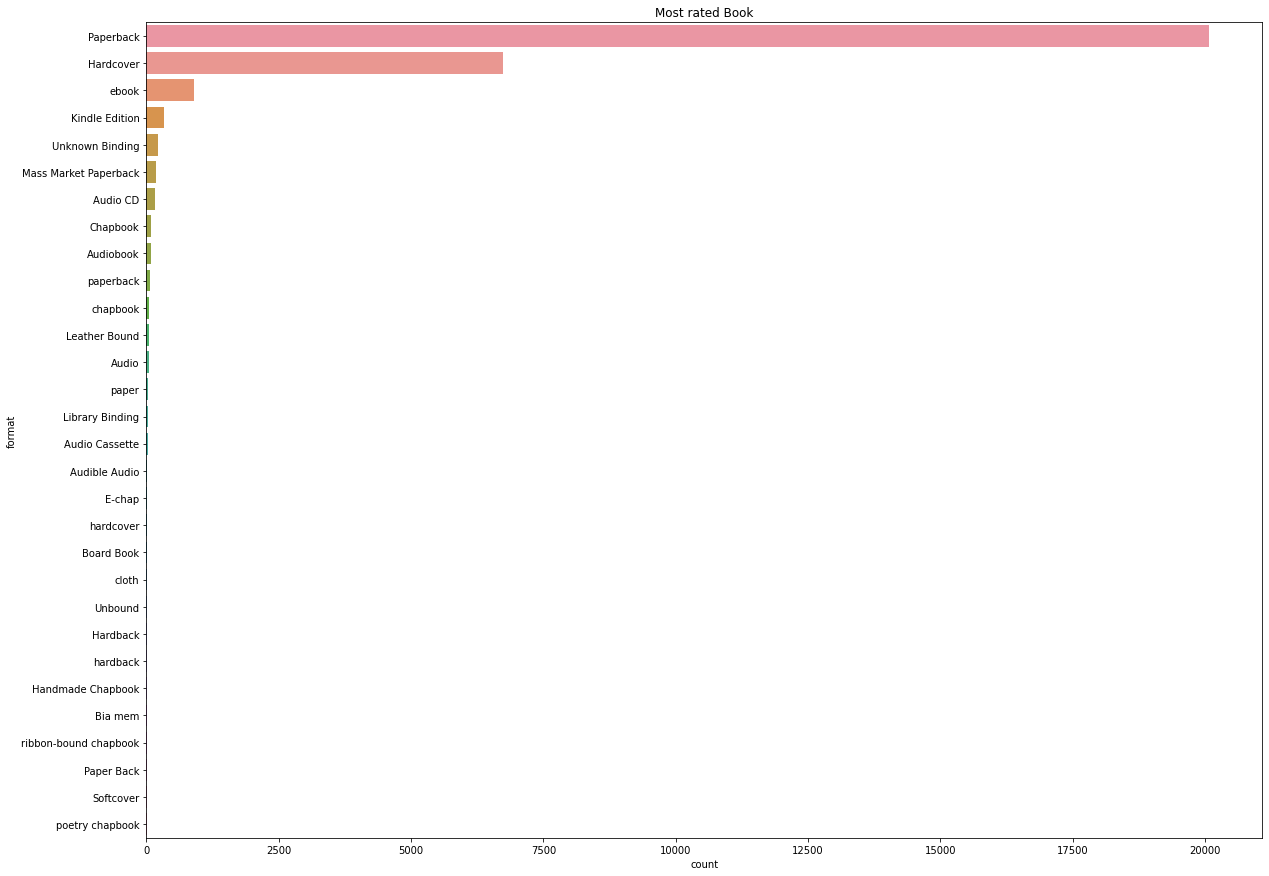

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Most rated Book")
sns.barplot(freq_format['count'], freq_format.format)

publisher

- bins 혹은 상위 pub 여부 encoding 가능

이번엔 일단 제거하고 나중에 추가

In [ ]:
book_data['publisher'].value_counts().describe()

count    8185.000000
mean        3.723274
std        13.071212
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       320.000000
Name: publisher, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='publisher'>

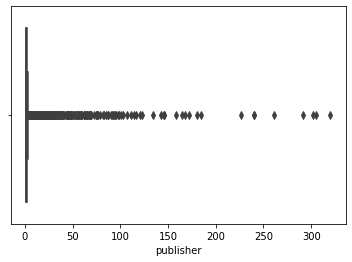

In [ ]:
sns.boxplot(book_data['publisher'].value_counts())

similar_books 

In [ ]:
book_data['similar_books']

0                                                      NaN
1                                                      NaN
2                                                      NaN
3                                                      NaN
4                                                      NaN
                               ...                        
36501                                                  NaN
36502                                                  NaN
36503                                                  NaN
36504    [60321, 25135410, 1312362, 7146660, 17824744, ...
36505                                                  NaN
Name: similar_books, Length: 36506, dtype: object

- 나중에 처리

___

#### book 최종

In [ ]:
book_data_final = book_data.drop(['popular_shelves','authors','language_code','format','publisher','author_id','similar_books'],axis=1)
book_data_final = book_data_final.dropna(how='any') #빠른 처리를 위해서 전부 drop
book_data_final = book_data_final[['title','author_name','book_id','url','is_ebook','is_eng','num_pages','publication_year',\
                                   'publication_month','publication_day','average_rating','to_read','ratings_count',\
                                  'text_reviews_count','author_average_rating','author_ratings_count','author_text_reviews_count']]
book_data_final

,title,author_name,book_id,url,is_ebook,is_eng,num_pages,publication_year,publication_month,publication_day,average_rating,to_read,ratings_count,text_reviews_count,author_average_rating,author_ratings_count,author_text_reviews_count
0,Vision of Sir Launfal and Other Poems,James Russell Lowell,16037549,https://www.goodreads.com/book/show/16037549-v...,0,1,80.0,1887.0,11.0,1.0,3.83,8,3,1,4.03,1464,158
1,Fairy Tales: Dramolettes,Robert Walser,22466716,https://www.goodreads.com/book/show/22466716-f...,0,0,128.0,2015.0,4.0,20.0,3.83,100,37,2,4.02,10359,1079
2,Thirty Poems,Robert Walser,13447246,https://www.goodreads.com/book/show/13447246-t...,0,1,64.0,2012.0,5.0,31.0,3.79,30,39,4,4.02,10359,1079
3,Oppressive Light: Selected Poems by Robert Walser,Robert Walser,12740665,https://www.goodreads.com/book/show/12740665-o...,0,0,200.0,2012.0,8.0,7.0,4.46,60,26,5,4.02,10359,1079
5,The Cocktail Party,T.S. Eliot,926667,https://www.goodreads.com/book/show/926667.The...,0,0,190.0,1964.0,3.0,18.0,3.71,554,115,12,4.17,189956,5892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,"What's for Dinner?: Quirky, Squirmy Poems from...",Katherine B. Hauth,9150712,https://www.goodreads.com/book/show/9150712-wh...,0,0,48.0,2011.0,2.0,1.0,3.57,30,47,18,3.58,55,23
36496,A Poem for Record Keepers,Ali Power,29951330,https://www.goodreads.com/book/show/29951330-a...,0,0,79.0,2016.0,5.0,1.0,4.27,9,11,2,4.27,11,2
36499,When it Rains in the Desert,Carol Creelawn,31539894,https://www.goodreads.com/book/show/31539894-w...,0,0,80.0,2016.0,8.0,11.0,3.62,438,4,2,3.62,8,4
36503,Elapsing Speedway Organism,Bruce Covey,1330132,https://www.goodreads.com/book/show/1330132.El...,0,0,108.0,2006.0,9.0,21.0,4.83,16,23,1,4.64,85,8


In [ ]:
book_data_final.isnull().sum()

title                        0
author_name                  0
book_id                      0
url                          0
is_ebook                     0
is_eng                       0
num_pages                    0
publication_year             0
publication_month            0
publication_day              0
average_rating               0
to_read                      0
ratings_count                0
text_reviews_count           0
author_average_rating        0
author_ratings_count         0
author_text_reviews_count    0
dtype: int64

In [ ]:
book_data_log = book_data_final.copy()
book_data_log['to_read'] = np.log1p(book_data_log['to_read'])
book_data_log['text_reviews_count'] = np.log1p(book_data_log['text_reviews_count'])
book_data_log['ratings_count'] = np.log1p(book_data_log['ratings_count'])
book_data_log['num_pages'] = np.log1p(book_data_log['num_pages'])
book_data_log['author_text_reviews_count'] = np.log1p(book_data_log['author_text_reviews_count'])
book_data_log['author_ratings_count'] = np.log1p(book_data_log['author_ratings_count'])

book_data_log

,title,author_name,book_id,url,is_ebook,is_eng,num_pages,publication_year,publication_month,publication_day,average_rating,to_read,ratings_count,text_reviews_count,author_average_rating,author_ratings_count,author_text_reviews_count
0,Vision of Sir Launfal and Other Poems,James Russell Lowell,16037549,https://www.goodreads.com/book/show/16037549-v...,0,1,4.394449,1887.0,11.0,1.0,3.83,2.197225,1.386294,0.693147,4.03,7.289611,5.068904
1,Fairy Tales: Dramolettes,Robert Walser,22466716,https://www.goodreads.com/book/show/22466716-f...,0,0,4.859812,2015.0,4.0,20.0,3.83,4.615121,3.637586,1.098612,4.02,9.245708,6.984716
2,Thirty Poems,Robert Walser,13447246,https://www.goodreads.com/book/show/13447246-t...,0,1,4.174387,2012.0,5.0,31.0,3.79,3.433987,3.688879,1.609438,4.02,9.245708,6.984716
3,Oppressive Light: Selected Poems by Robert Walser,Robert Walser,12740665,https://www.goodreads.com/book/show/12740665-o...,0,0,5.303305,2012.0,8.0,7.0,4.46,4.110874,3.295837,1.791759,4.02,9.245708,6.984716
5,The Cocktail Party,T.S. Eliot,926667,https://www.goodreads.com/book/show/926667.The...,0,0,5.252273,1964.0,3.0,18.0,3.71,6.318968,4.753590,2.564949,4.17,12.154553,8.681520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,"What's for Dinner?: Quirky, Squirmy Poems from...",Katherine B. Hauth,9150712,https://www.goodreads.com/book/show/9150712-wh...,0,0,3.891820,2011.0,2.0,1.0,3.57,3.433987,3.871201,2.944439,3.58,4.025352,3.178054
36496,A Poem for Record Keepers,Ali Power,29951330,https://www.goodreads.com/book/show/29951330-a...,0,0,4.382027,2016.0,5.0,1.0,4.27,2.302585,2.484907,1.098612,4.27,2.484907,1.098612
36499,When it Rains in the Desert,Carol Creelawn,31539894,https://www.goodreads.com/book/show/31539894-w...,0,0,4.394449,2016.0,8.0,11.0,3.62,6.084499,1.609438,1.098612,3.62,2.197225,1.609438
36503,Elapsing Speedway Organism,Bruce Covey,1330132,https://www.goodreads.com/book/show/1330132.El...,0,0,4.691348,2006.0,9.0,21.0,4.83,2.833213,3.178054,0.693147,4.64,4.454347,2.197225


___

### action

In [ ]:
action

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,1384,1bad0122cebb4aa9213f9fe1aa281f66,1,4,NaN,Wed May 09 09:33:44 -0700 2007,Wed May 09 09:33:44 -0700 2007,NaN,NaN
1,8842281e1d1347389f2ab93d60773d4d,1376,eb6e502d0c04d57b43a5a02c21b64ab4,1,4,NaN,Wed May 09 09:33:18 -0700 2007,Wed May 09 09:33:18 -0700 2007,NaN,NaN
2,8842281e1d1347389f2ab93d60773d4d,30119,787564bef16cb1f43e0f641ab59d25b7,1,5,NaN,Sat Jan 13 13:44:20 -0800 2007,Wed Mar 22 11:45:08 -0700 2017,Tue Mar 01 00:00:00 -0800 1983,NaN
3,72fb0d0087d28c832f15776b0d936598,24769928,8c80ee74743d4b3b123dd1a2e0c0bcac,0,0,NaN,Wed Apr 27 11:05:51 -0700 2016,Wed Apr 27 11:05:52 -0700 2016,NaN,NaN
4,72fb0d0087d28c832f15776b0d936598,30119,2a83589fb597309934ec9b1db5876aaf,1,3,NaN,Mon Jun 04 18:58:08 -0700 2012,Mon Jun 04 18:58:13 -0700 2012,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2734345,594c86711bd7acdaf655d102df52a9cb,10810038,1b6982ab9342de8d0c560f74598b7b95,0,0,NaN,Thu May 23 12:54:29 -0700 2013,Thu May 23 12:54:29 -0700 2013,NaN,NaN
2734346,594c86711bd7acdaf655d102df52a9cb,4488657,6fccf41aad2ef9d4392b2dc0c14cf77c,0,0,NaN,Sun Apr 28 09:26:58 -0700 2013,Sun Apr 28 09:27:11 -0700 2013,NaN,NaN
2734347,594c86711bd7acdaf655d102df52a9cb,5865674,dea3556a048fc6b75f361baeaa0c49e9,0,0,NaN,Sun Apr 28 09:25:28 -0700 2013,Sun Apr 28 09:25:28 -0700 2013,NaN,NaN
2734348,594c86711bd7acdaf655d102df52a9cb,16170625,a3d153de0b86bdf9eeef0d756f471649,1,5,NaN,Sun Apr 21 16:29:46 -0700 2013,Fri May 31 10:29:35 -0700 2013,NaN,NaN


In [ ]:
action.isnull().sum()

user_id                         0
book_id                         0
review_id                       0
is_read                         0
rating                          0
review_text_incomplete    2578936
date_added                      0
date_updated                    0
read_at                   2309891
started_at                2416528
dtype: int64

In [ ]:
action.nunique()

user_id                    377799
book_id                     36514
review_id                 2734350
is_read                         2
rating                          6
review_text_incomplete     153014
date_added                2701952
date_updated              2648504
read_at                    247035
started_at                 153936
dtype: int64

##### review_text_incomplete, read_at, started_at : 결측치가 너무 많기 때문에  drop
#### review_id : 모두 unique 값

#### is_read와 rating 분포를 통해 대부분 is_read가 0이면 rating도 0임을 알 수 있다.

- is_read, rating이 0인 성분 drop

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_read', ylabel='count'>

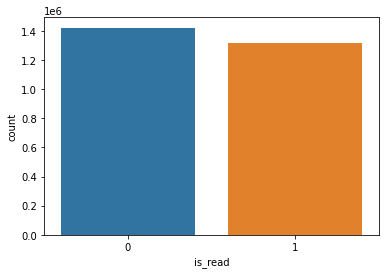

In [ ]:
sns.countplot('is_read', data = action)

In [ ]:
action['rating'].value_counts()

0    1505291
5     500971
4     405565
3     237942
2      64084
1      20497
Name: rating, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='rating', ylabel='count'>

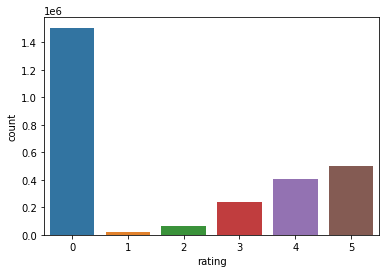

In [ ]:
sns.countplot('rating', data = action)

In [ ]:
action = action[(action['is_read'] != 0) | (action['rating'] != 0)]

date_added, date_updated 

- 추출하면 timestamp 얻을 수 있을 것이다.

#### action 최종

In [ ]:
action_final = action.drop(['review_id','is_read','review_text_incomplete','date_added','date_updated','read_at','started_at'],axis = 1)
action_final

,user_id,book_id,rating
0,8842281e1d1347389f2ab93d60773d4d,1384,4
1,8842281e1d1347389f2ab93d60773d4d,1376,4
2,8842281e1d1347389f2ab93d60773d4d,30119,5
4,72fb0d0087d28c832f15776b0d936598,30119,3
5,ab2923b738ea3082f5f3efcbbfacb218,240007,4
...,...,...,...
2734340,148e49f7ed14137ff13a9a31c770487d,2547,5
2734341,da6f9516279ed671027308abd21318bd,11047097,4
2734343,594c86711bd7acdaf655d102df52a9cb,7433930,5
2734348,594c86711bd7acdaf655d102df52a9cb,16170625,5


In [ ]:
action_final.isnull().sum()

user_id    0
book_id    0
rating     0
dtype: int64

### 데이터 저장

In [ ]:
book_csv_name = os.path.join(file_path,'book_data.csv')
book_log_csv_name = os.path.join(file_path,'book_data_log.csv')
action_csv_name = os.path.join(file_path,'action_data.csv')

book_data_final.to_csv(book_csv_name, mode='w')
book_data_log.to_csv(book_log_csv_name, mode='w')
action_final.to_csv(action_csv_name, mode='w')

___

### 상관 계수 시각화

In [ ]:
book_heatmap = book_data_final.drop(['title','author_name','book_id','url'],axis = 1)
book_log_heatmap = book_data_log.drop(['title','author_name','book_id','url'],axis = 1)
columns = ['to_read','is_ebook','is_eng','num_pages','publication_year',\
                                   'publication_month','publication_day','average_rating','ratings_count',\
                                  'text_reviews_count','author_average_rating','author_ratings_count','author_text_reviews_count']

book_heatmap = book_heatmap[columns]
book_log_heatmap = book_log_heatmap[columns]

book_cor = book_heatmap.astype(float).corr()
book_log_cor = book_log_heatmap.astype(float).corr()
book_spear_cor = book_heatmap.astype(float).corr(method='spearman')
book_log_spear_cor = book_log_heatmap.astype(float).corr(method='spearman')

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

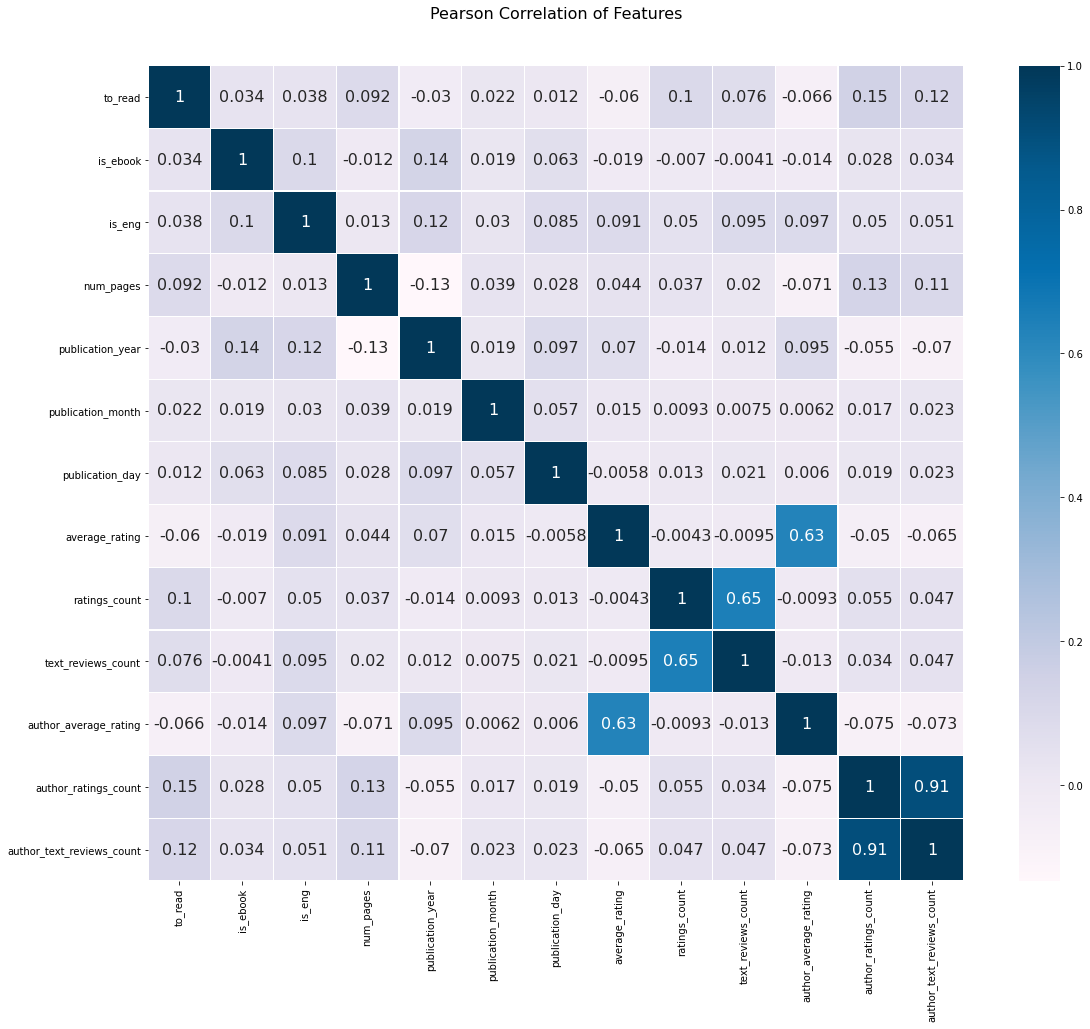

In [ ]:
colormap = plt.cm.PuBu
plt.figure(figsize=(20, 15))
plt.title("Pearson Correlation of Features", y = 1.05, size = 16)
sns.heatmap(book_cor, linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, \
            linecolor = "white", annot = True, annot_kws = {"size" : 16})

#### log한 데이터가 전반적으로 corr가 높다

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

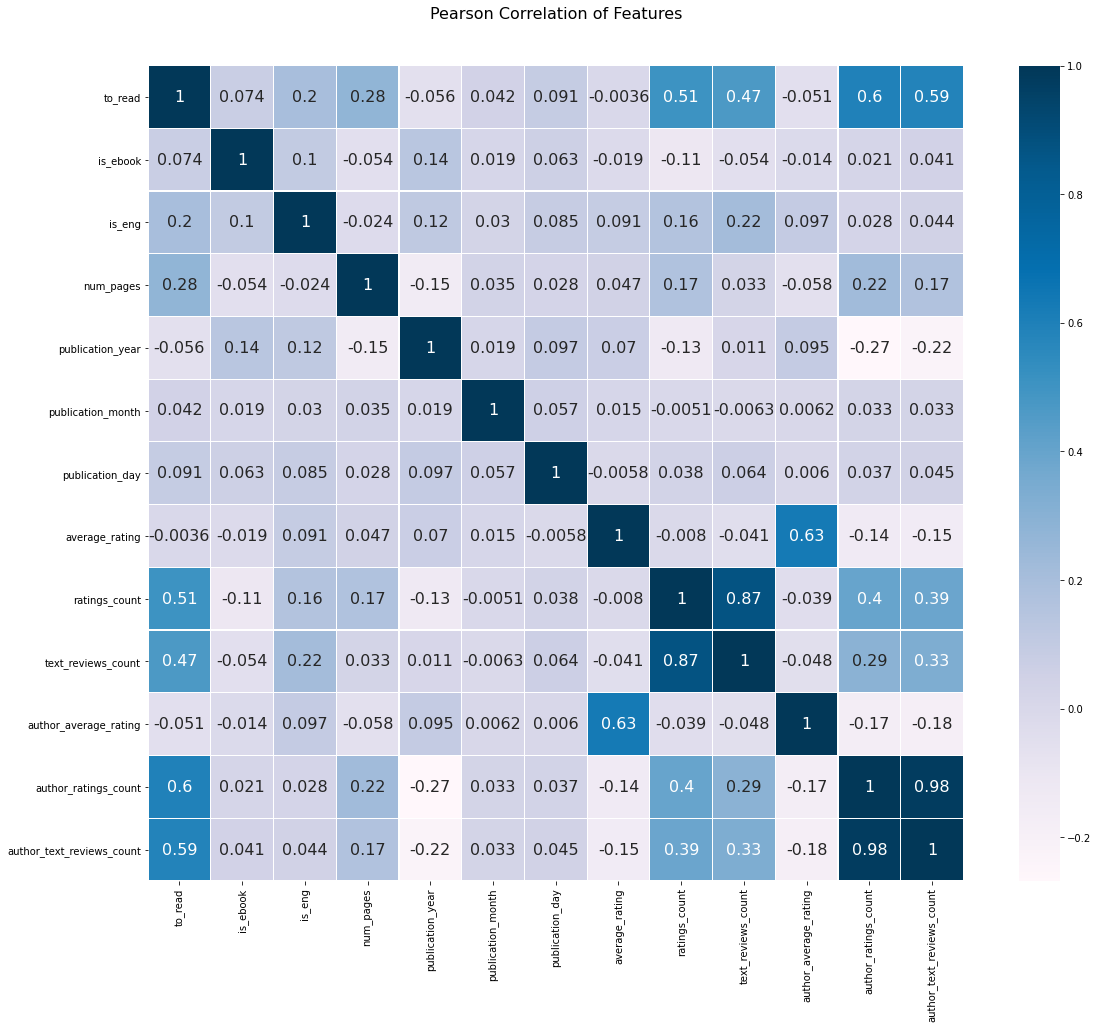

In [ ]:
colormap = plt.cm.PuBu
plt.figure(figsize=(20, 15))
plt.title("Pearson Correlation of Features", y = 1.05, size = 16)
sns.heatmap(book_log_cor, linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, \
            linecolor = "white", annot = True, annot_kws = {"size" : 16})

<AxesSubplot:title={'center':'Spearman Correlation of Features'}>

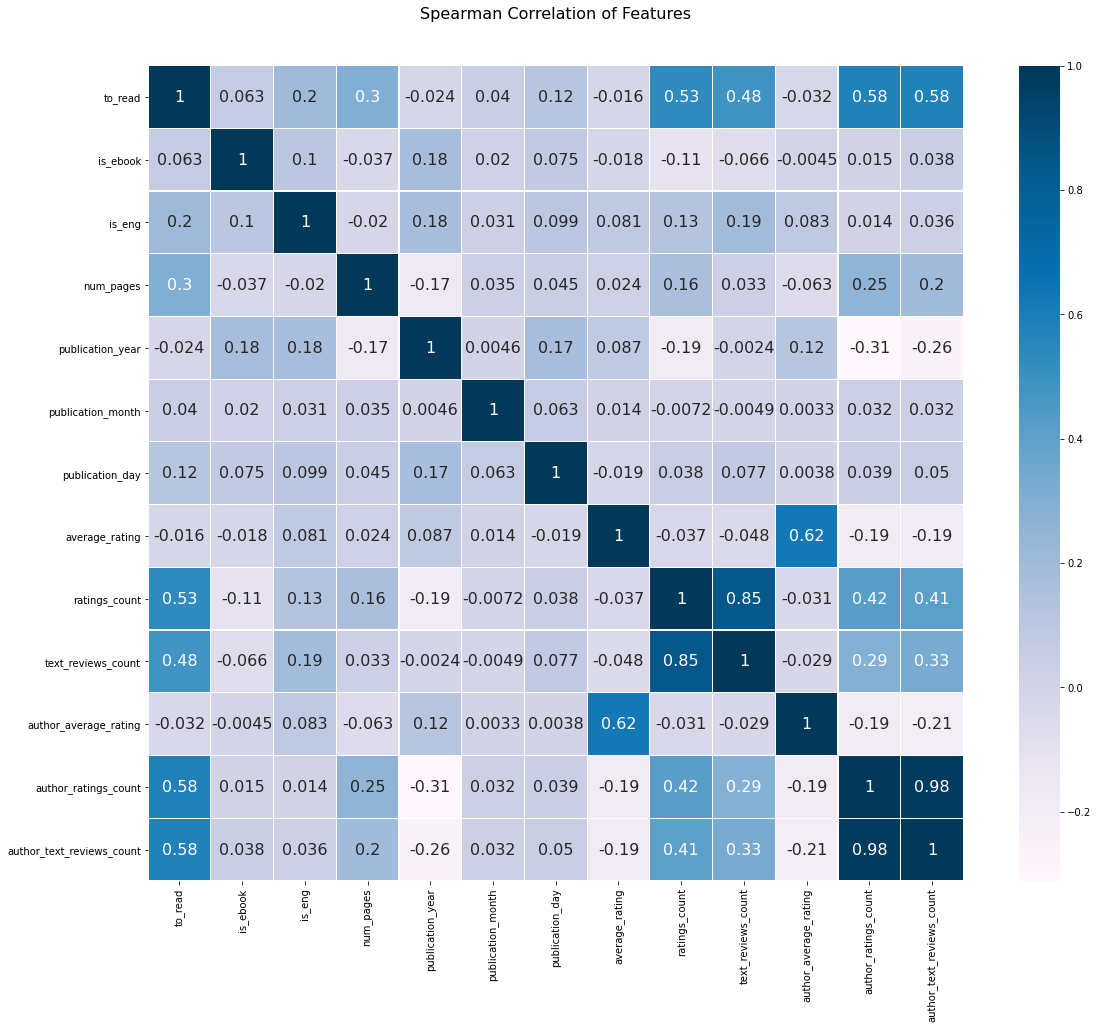

In [ ]:
colormap = plt.cm.PuBu
plt.figure(figsize=(20, 15))
plt.title("Spearman Correlation of Features", y = 1.05, size = 16)
sns.heatmap(book_spear_cor, linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, \
            linecolor = "white", annot = True, annot_kws = {"size" : 16})

- 일부 수치형 변수를 log 정규화한 결과 변수 사이 correlation 계수가 전반적으로 올랐습니다.

- **to_read 부터 author_text_reviews_count**사이에 속한 컬럼끼리의 높은 상관 계수를 확인할 수 있습니다.    
특히 text_reviews_count(author)와 ratings_count(author) 상관 계수는 매우 높아 별도의 처리가 필요하다고 생각됩니다,

___